In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import pandas as pd

/home/paulina/.anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


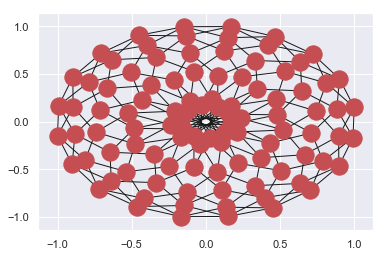

In [24]:
m = 100
g = nx.convert_node_labels_to_integers(nx.grid_2d_graph(int(m**0.5),int(m**0.5),True))
layout = nx.kamada_kawai_layout(g)
nx.draw_networkx(g,layout,False,False)

## Założenia modelu
- Populacja jest stała
- Osoba podatna może zostać zarażona od sąsiada z prawdopodobieństwem $\beta$ lub zaszczepiona z prawdopodobieństwem $\phi$
- Osoba zarażona może wyleczyć się (i zostać odpornym) z prawdopodobieństwem $\gamma$
- Osoba zaszczepiona jest odporniejsza od podatnej o czynnik $\delta \to $prawdopodobieństwo zarażenia - $\beta \delta$

In [3]:
beta = 0.24 # prawdopodobieństwo zarażenia
phi = 0.0 # prawdopodobieństwo zaszczepienia
gamma = 0.02 # prawdopodobieństwo wyleczenia
delta = 1/13 # wzmocnienie odporności

- o - (S) podatny
- 1 - (I) zakażony
- 2 - (R) odporny
- 3 - (V) zaszczepiony

In [4]:
def SIRV_init(g,init_i=0,init_r=0,init_v=0):
    n = g.number_of_nodes()
#     nx.set_node_attributes(g,0,'status')
    status = np.concatenate((np.zeros(n-init_i-init_r-init_v),np.ones(init_i),np.ones(init_r)*2,np.ones(init_v)*3))
    np.random.shuffle(status)
    for i in range(n):
        g.nodes[i]['status'] = status[i]
    return status
    
#     Drawing
def drawing(g,status=None,folder=None,i=0,display=False):
    warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)
    warnings.filterwarnings("ignore",category=RuntimeWarning)
    
    fig, ax = plt.subplots()    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
#     ax.axis('off')
    
    layout = nx.kamada_kawai_layout(g)
    nx.draw_networkx_edges(g,layout)
    if status is None:
        S = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 0]
        I = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 1]
        R = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 2]
        V = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 3]
    else:
        n = len(status)
        S = [index for index in range(n) if status[index] == 0]
        I = [index for index in range(n) if status[index] == 1]
        R = [index for index in range(n) if status[index] == 2]
        V = [index for index in range(n) if status[index] == 3]
    nx.draw_networkx_nodes(g,layout,nodelist=S,node_size=200,node_color='#95d0fc')
    nx.draw_networkx_nodes(g,layout,nodelist=I,node_size=200,node_color="#980002")
    nx.draw_networkx_nodes(g,layout,nodelist=R,node_size=200,node_color='#06470c')
    nx.draw_networkx_nodes(g,layout,nodelist=V,node_size=200,node_color='#0504aa')
    if folder is not None:
#         sns.despine(top=True, right=True, left=True, bottom=True)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(os.path.join(folder, f"{i:03}.png"),dpi=400)
    plt.close(fig)
    return {"S":len(S), "I":len(I), "R":len(R), "V":len(V)}

def count_states(g,status=None):
    if status is None:
        S = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 0]
        I = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 1]
        R = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 2]
        V = [key for key,value in nx.get_node_attributes(g,'status').items() if value == 3]
    else:
        n = len(status)
        S = [index for index in range(n) if status[index] == 0]
        I = [index for index in range(n) if status[index] == 1]
        R = [index for index in range(n) if status[index] == 2]
        V = [index for index in range(n) if status[index] == 3]
        
    return {"S":len(S), "I":len(I), "R":len(R), "V":len(V)}

In [5]:
def SIRV(g,steps=1,beta=beta,gamma=gamma,phi=phi,delta=delta,status=None):
    if status is None:
        for i in range(steps):
            last_status = [val for key,val in nx.get_node_attributes(g,'status').items()]
            for n in range(g.number_of_nodes()):
                change_chance = np.random.rand()
                status_n = last_status[n]
                neighbors = g.neighbors(n)
                if(status_n == 0):
                    infected_neighbors = [n for n in neighbors if last_status[n] == 1]
                    if change_chance < 1 - (1 - beta)**len(infected_neighbors):
                        g.nodes[n]['status'] = 1
                    elif np.random.rand() < phi:
                        g.nodes[n]['status'] = 3
                elif(status_n == 1):
                    if change_chance < gamma:
                        g.nodes[n]['status'] = 2
                elif(status_n == 3):
                    infected_neighbors = [n for n in neighbors if last_status[n] == 1]
                    triggered = 1 if len(infected_neighbors) > 0 else 0
                    if change_chance < delta*beta*triggered:
                        g.nodes[n]['status'] = 1
        status = [val for key,val in nx.get_node_attributes(g,'status').items()]
    else:
        actual_status = status
        for i in range(steps):
            for n in range(len(status)):
                change_chance = np.random.rand()
                status_n = status[n]
                neighbors = g.neighbors(n)
                if(status_n == 0):
                    infected_neighbors = [n for n in neighbors if status[n] == 1]
                    triggered = 1 if len(infected_neighbors) > 0 else 0
                    if change_chance < beta*triggered:
                        actual_status[n] = 1
                    elif np.random.rand() < phi:
                        actual_status[n] = 3
                elif(status_n == 1):
                    if change_chance < gamma:
                        actual_status[n] = 2
                elif(status_n == 3):
                    infected_neighbors = [n for n in neighbors if status[n] == 1]
                    triggered = 1 if len(infected_neighbors) > 0 else 0
                    if change_chance < delta*beta*triggered:
                        actual_status = 1
            status = actual_status
    return status

In [6]:
iterations = 100
status = SIRV_init(g,5)
states = [drawing(g,status,"SIRV_measles_13")]
for i in tqdm(range(iterations)):
    status = SIRV(g,1,0.24,0.2,0.2,1/13)
    states.append(drawing(g,status,"SIRV_measles_13",i+1))
states = pd.DataFrame.from_dict(states)

In [29]:
summary = None
N = 10
iterations = 100
for j in tqdm(range(N)):
    status = SIRV_init(g,1)
    states = [count_states(g,status)]
    for i in range(iterations):
        status = SIRV(g,status=status)
        states.append(count_states(g,status))
    states = pd.DataFrame.from_dict(states)
    if summary is None:
        summary = states.copy()
    else:
        summary = summary + states
summary = summary / N

In [ ]:
iterations = np.linspace(0,len(summary),len(summary))
sns.set()
plt.plot(iterations,summary['S'],'C0-',label='S')
plt.plot(iterations,summary['I'],'C1--',label='I')
plt.plot(iterations,summary['R'],'C2-.',label='R')
# plt.plot(iterations,summary['V'],'C3:',label='V')
plt.legend()
plt.xlabel('t')
plt.ylabel('% populacji')
if phi == 0:
    plt.title("SIR\n" fr"$\beta$={beta} $\gamma$={gamma}")
    plt.savefig(f'SIR_0V_sym.png',dpi=400)
else:
    plt.title("SIRV\n" fr"$\beta$={beta} $\gamma$={gamma} $\phi$={phi} $\delta$={delta:.3}")
    plt.savefig(f'SIRV_beta={beta}_gamma={gamma}_phi={phi}_delta={delta:.3}.png',dpi=400)

In [29]:
def dS(S, I, beta, N):
    return -S*I*beta/N
def dI(S, I, beta, gamma, N):
    return S*I*beta/N - gamma*I
def dR(I, gamma):
    return I*gamma

def dF(t, r, beta, N, gamma):
    S, I, R = r
    return [dS(S, I, beta, N), dI(S, I, beta, gamma, N), dR(I, gamma)]

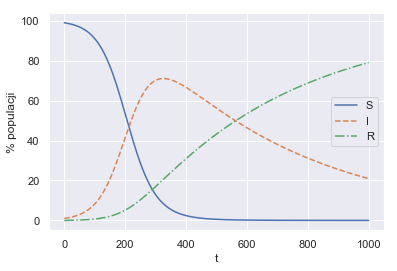

In [45]:
from scipy.integrate import solve_ivp
N = 100
S = [N-1]
I = [1]
R = [0]
y0 = [N-1, 1, 0]
solution = solve_ivp(lambda t, r: dF(t, r, beta, N, gamma), t_span=(0, 100), y0=y0, dense_output=True)
S, I, R = solution.sol(np.linspace(0, 100, 1000))
# for i in range(100):
#     S.append(S[i]+dS(S[i], I[i], beta, N))
#     I.append(I[i]+dI(S[i], I[i], beta, gamma, N))
#     R.append(R[i]+dR(I[i],gamma))
    
sns.set()
plt.plot(S,'C0-',label='S')
plt.plot(I,'C1--',label='I')
plt.plot(R,'C2-.',label='R')
plt.legend()
plt.xlabel('t')
plt.ylabel('% populacji')
plt.savefig(f'SIR_0V_ana.png',dpi=400)

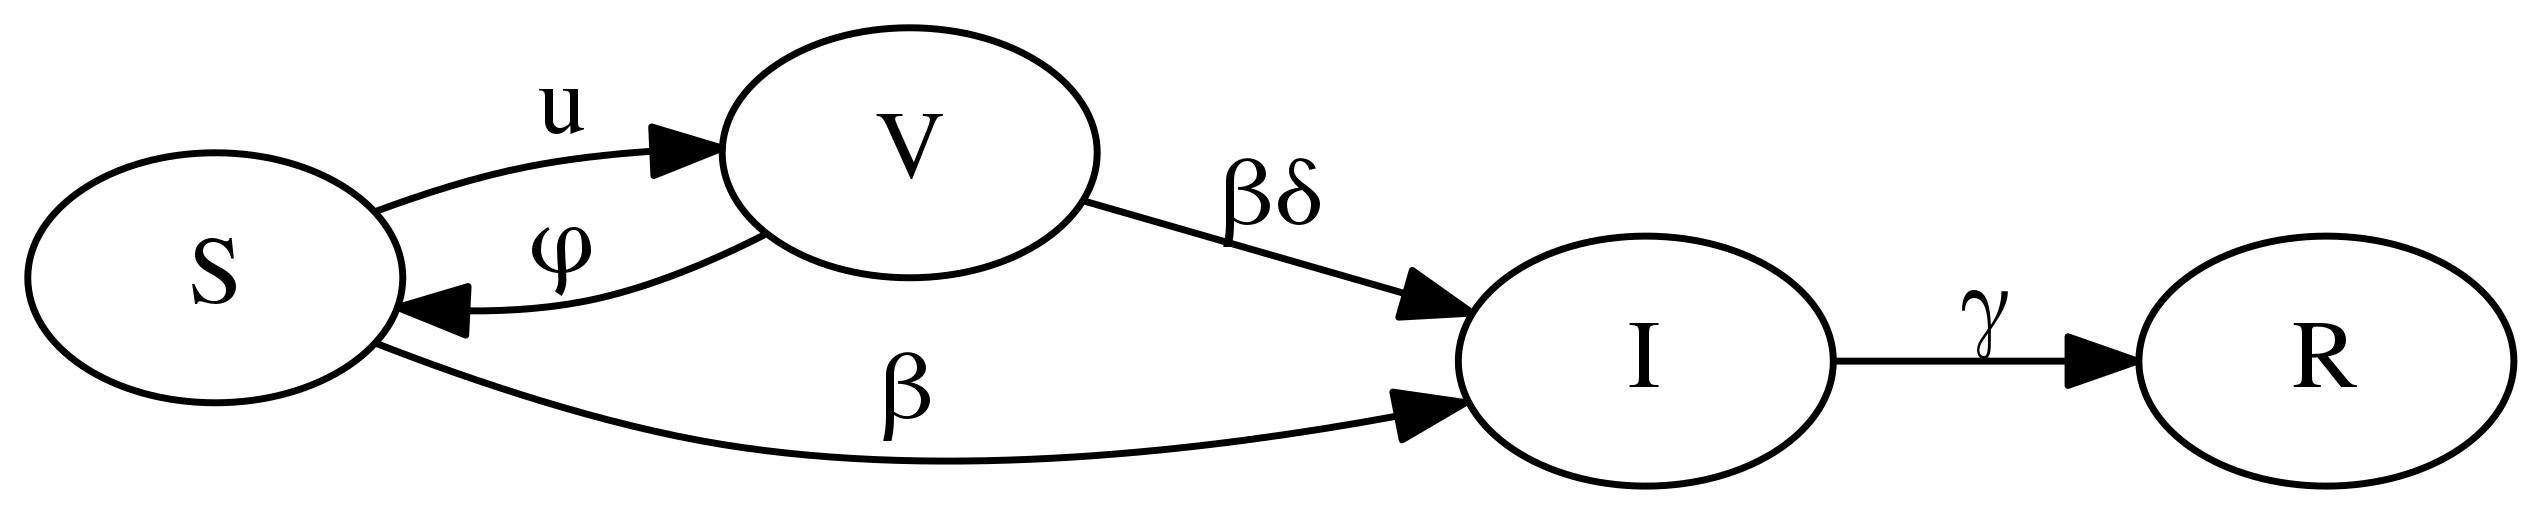

In [3]:
from IPython.display import Image
import pydot
graph = pydot.Dot(graph_type='digraph',rankdir="LR",dpi=500)
graph.add_edge(pydot.Edge("S","V", label=r"u"))
graph.add_edge(pydot.Edge("V","S", label=r"φ"))
graph.add_edge(pydot.Edge("V","I", label=r"βδ"))
graph.add_edge(pydot.Edge("S","I", label=r"β"))
graph.add_edge(pydot.Edge("I","R", label=r"γ"))
plt = Image(graph.create_png())
display(plt)
graph.write_png("graph_SIRV.png")

In [47]:
for i in tqdm(range(15,100,15)):
    summary = None
    N = 10
    iterations = 100
    for j in range(N):
        status = SIRV_init(g,1,i)
        states = [count_states(g,status)]
        for k in range(iterations):
            status = SIRV(g,status=status)
            states.append(count_states(g,status))
        states = pd.DataFrame.from_dict(states)
        if summary is None:
            summary = states.copy()
        else:
            summary = summary + states
    summary = summary / N
    iterations = np.linspace(0,len(summary),len(summary))
    sns.set()
    plt.plot(iterations,summary['S'],'C0-',label='S')
    plt.plot(iterations,summary['I'],'C1--',label='I')
    plt.plot(iterations,summary['R'],'C2-.',label='R')
    # plt.plot(iterations,summary['V'],'C3:',label='V')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('% populacji')
    plt.savefig(f'SIR_{i}V_sym.png',dpi=400)
    plt.close()
    
    M = 100
    y0 = [M-1-i, 1, i]
    solution = solve_ivp(lambda t, r: dF(t, r, beta, M, gamma), t_span=(0, 100), y0=y0, dense_output=True)
    S, I, R = solution.sol(np.linspace(0, 100, 1000))

    plt.plot(S,'C0-',label='S')
    plt.plot(I,'C1--',label='I')
    plt.plot(R,'C2-.',label='R')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('% populacji')
    plt.savefig(f'SIR_{i}V_ana.png',dpi=400)
    plt.close()